+ **목적** : 리뷰글의 긍정/부정 예측을 위한 모델 생성

In [1]:
# Colab에 Mecab 설치
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh

In [ ]:
# PyKoSpacing 설치
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
# from konlpy.tag import Mecab
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# wordcloud 준비
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)          


### 1.자료 불러오기 : 티몬 리뷰

In [66]:
##########
# 자료 불러오기
#####

# 전체 자료 불러오기 & 병합
df = pd.read_excel('./라이브방송_궁.xlsx', 'Sheet1')

In [68]:
df.head(10)

,TEXT,GUBUN,SET1,SET2
0,반가워요♡,중립,소통참여,소통참여
1,안녕하세여!,중립,소통참여,소통참여
2,안녕하세요,중립,소통참여,소통참여
3,안뇽하세욧^^,중립,소통참여,소통참여
4,지난번 라방 사서 먹고 있는데 또 쟁이려구요^^,중립,소통참여,소통참여
5,반갑습니다,중립,소통참여,소통참여
6,핫딜 상품 얼른 소개해주세여!,중립,소통참여,소통참여
7,가족들 모두 선물받고 좋아해요!,긍정,소통참여,소통참여
8,안녕하세요,중립,소통참여,소통참여
9,셀렉스 너무 좋아요,긍정,소통참여,소통참여


In [6]:
df.groupby(['GUBUN']).count()

,TEXT,SET1,SET2
GUBUN,,,
긍정,698,698,698
문의,87,87,87
부정,5,5,5
중립,1052,1052,1052


In [71]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
df['label'] = ord_enc.fit_transform(df[['GUBUN']])

In [11]:
df.groupby(['label']).count()

,TEXT,GUBUN,SET1,SET2
label,,,,
0.0,698,698,698,698
1.0,87,87,87,87
2.0,5,5,5,5
3.0,1052,1052,1052,1052


### 2.데이터 전처리/Set 분류

In [72]:
# 데이터 전처리
df['TEXT'] = df['TEXT'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# df['TEXT'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
# df = df.dropna(how='any') # Null 값 제거

In [73]:
df.tail()

,TEXT,GUBUN,SET1,SET2,label
1837,세상쉬운 피부관리,긍정,소통참여,소통참여,0.0
1838,잘 먹을께요,중립,소통참여,소통참여,3.0
1839,저두 늦지 않았나요ㅎㅎ,중립,소통참여,소통참여,3.0
1840,당첨됐으면,중립,소통참여,소통참여,3.0
1841,감사해요,중립,소통참여,소통참여,3.0


In [74]:
df1 = df[['TEXT', 'label']]

In [75]:
# Set 분류
train_data, test_data = train_test_split(df1, test_size = 0.15, random_state = 42)

In [76]:
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 1565
테스트용 리뷰의 개수 : 277


In [77]:
test_data.values[:5]

array([['언니 제 피부 살려주세여', 3.0],
       ['리코님 우리부모님께도 맛있게 드시라고 구매했어요 콜라겐 영양 챙기시라고 구매했어요완전 이쁘지시라고 아빠도 관리하고싶으시다고하셔서요 구매 생신선물사드렸어요',
        0.0],
       ['세라마이드 에 콜라겐 비타민까지 있다니 좋네요', 0.0],
       ['이야 이거 먹고 우리 리코님처럼 이뻐집시다', 3.0],
       ['와우', 3.0]], dtype=object)

In [78]:
from konlpy.tag import Okt
okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")
okt = Okt()

In [79]:
def tokenize(doc):
    #형태소와 품사를 join
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

In [80]:
# %%time
train_docs = [(tokenize(row[0]), row[1]) for row in train_data.values]
test_docs = [(tokenize(row[0]), row[1]) for row in test_data.values]

In [81]:
print(train_docs[0])

(['늦다/Verb', '샛째/Noun', '까지/Josa', '낳다/Verb', '아이/Noun', '들/Suffix', '케어/Noun', '하다/Verb', '보다/Verb', '피부/Noun', '가/Josa', '건/Noun', '도/Josa', '하다못해/Adverb', '간지럽다/Adjective', '이/Determiner', '젠/Noun', '기초/Noun', '화장품/Noun', '도/Josa', '안/Noun', '받다/Verb', 'ㅠㅠ/KoreanParticle'], 3.0)


In [82]:
tokens = [t for d in train_docs for t in d[0]]
print("토큰개수:", len(tokens))

토큰개수: 11603


In [83]:
import nltk
text = nltk.Text(tokens, name='NMSC')

#토큰개수
print(len(text.tokens))

#중복을 제외한 토큰개수
print(len(set(text.tokens)))

#출력빈도가 높은 상위 토큰 10개
print(text.vocab().most_common(10))

11603
1342
[('하다/Verb', 380), ('먹다/Verb', 341), ('좋다/Adjective', 261), ('세/Modifier', 229), ('라마/Noun', 227), ('이드/Noun', 221), ('도/Josa', 210), ('밀크/Noun', 183), ('에/Josa', 161), ('팩/Noun', 133)]


In [84]:
FREQUENCY_COUNT = 1000
selected_words = [f[0] for f in text.vocab().most_common(FREQUENCY_COUNT)]

In [85]:
#단어리스트 문서에서 상위 10000개들중 포함되는 단어들이 개수
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

In [86]:
#문서에 들어가는 단어 개수
x_train = [term_frequency(d) for d,_ in train_docs]
x_test = [term_frequency(d) for d,_ in test_docs]

In [87]:
#라벨(1 or 0)
y_train = [c for _,c in train_docs]
y_test = [c for _,c in test_docs]

In [88]:
x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [99]:
import tensorflow as tf

#레이어 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(FREQUENCY_COUNT,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [100]:
#학습 프로세스 설정
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[tf.keras.metrics.binary_accuracy]
    )

In [101]:
#학습 데이터로 학습
model.fit(x_train, y_train, epochs=10, batch_size=512)

Epoch 1/10


ValueError: in user code:

    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:174 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 3) vs (None, 1))


In [92]:
results = model.evaluate(x_test, y_test)

9/9 [==============================] - 0s 1ms/step - loss: -3.7965 - binary_accuracy: 0.0397


In [93]:
results

[-3.7965426445007324, 0.03971119225025177]

In [94]:
def predict_review(review):
    token = tokenize(review)
    tfq = term_frequency(token)
    data = np.expand_dims(np.asarray(tfq).astype('float32'), axis=0)
    score = float(model.predict(data))
    return score


In [95]:
TEXT_GUBN = []
for i in range(len(df)):
    temp = predict_review(df1['TEXT'][i])
    TEXT_GUBN.append(temp)

In [97]:
df1['TEXT_gubun'] = TEXT_GUBN

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
# df1.to_excel('data_check.xlsx', sheet_name= 'Sheet1' )

In [113]:
TEXT_LEN = []
for i in range(len(df)):
    temp = len(df1['TEXT'][i])
    TEXT_LEN.append(temp)

In [114]:
df1['TEXT_LEN'] = TEXT_LEN

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [119]:
df1[df1['TEXT_LEN']<7]

,TEXT,label,TEXT_gubun,TEXT_LEN
0,반가워요,3.0,0.937136,4
1,안녕하세여,3.0,0.907958,5
2,안녕하세요,3.0,0.907958,5
3,안뇽하세욧,3.0,0.973494,5
5,반갑습니다,3.0,0.937136,5
...,...,...,...,...
1831,와우,3.0,0.873475,2
1835,당첨 주문,3.0,0.968209,5
1838,잘 먹을께요,3.0,0.965715,6
1840,당첨됐으면,3.0,0.960609,5


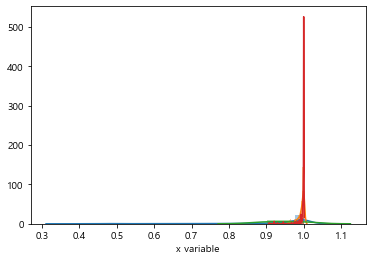

In [132]:
0# distplot
import pandas as pd
import seaborn as sns

x1 = pd.Series(df1[(df1['label']== 0 )& (df1['TEXT_LEN']> 15)]['TEXT_gubun'], name="x variable")
x2 = pd.Series(df1[(df1['label']== 1 )& (df1['TEXT_LEN']> 15)]['TEXT_gubun'], name="x variable")
x3 = pd.Series(df1[(df1['label']== 2 )& (df1['TEXT_LEN']> 15)]['TEXT_gubun'], name="x variable")
x4 = pd.Series(df1[(df1['label']== 3 )& (df1['TEXT_LEN']> 15)]['TEXT_gubun'], name="x variable")

ax = sns.distplot(x1)
ax = sns.distplot(x2)
ax = sns.distplot(x3)
ax = sns.distplot(x4)

plt.show()


In [126]:
df1[(df1['label']== 0 )& (df1['TEXT_LEN']> 7)]

,TEXT,label,TEXT_gubun,TEXT_LEN
7,가족들 모두 선물받고 좋아해요,0.0,0.894249,16
9,셀렉스 너무 좋아요,0.0,0.680782,10
13,혜자온니야 생방 시작 어녀 와 좋은 물건 나옴 빨리 빨리,0.0,0.915986,31
29,저 이거 먹고나서 신세계를 경험했어요 특가때마다 구매하러 옵니당,0.0,0.999453,35
31,셀렉스 밀크세라마이드 부담없이 먹기 좋아요 ㅎㅎ,0.0,0.988629,26
...,...,...,...,...
1815,셀렉스 비싼데 대박,0.0,0.829539,10
1818,지난번 구매한 석류맛 썬업이랑 같이 먹으면 짱짱,0.0,0.910578,26
1819,주분 주문입니당 두 번째 주문이라 체험분 개 득템입니당,0.0,0.982755,30
1828,진짜 이 가격에 넘넘 훌륭,0.0,0.745998,14
